Topic:  Application of ensemble learners in Music Emotion Recognition

Author:Vinuraj Devaraj

Problem Statement: Develop a classification model to classification musically induced emotions and determine range of frequencies associated with each emotion quadrant depicted in Russell's circumplex model. The annotated dataset called MER Audio Traffic data set (Panda, P., Malheiro, R. & Paiva, R. P. (2018). “Novel audio features for music emotion recognition”. IEEE Transactions on Affective Computing) is considered for developing a classification model and deriving the fequency framework. This dataset classifies 925 sound categorized into 4 emotion quadrants viz Q1, Q2,Q3 and Q4 based on Russell's Circumplex model of emotion.  The features extracted from the each sound signal, are collated into a csv file which would act as an input to the modelling process. The rest of the document illustrates modelling approach with Adaboost as an example. Other ensemble methods considered, for which the work is still in progress, are Gradient Boosting, Hist Gradient Boosting, Random Forest and Voting Classifier 

In [38]:
# import required libraries

# utilities
from IPython.display import Markdown as md
import librosa
import numpy as np
import random
import pandas as pd
import os

# stats
from scipy.stats import norm

# plotting
import matplotlib.pyplot as plt

# scikit - model development
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize

# Classification models
from sklearn.ensemble import AdaBoostClassifier,VotingClassifier,BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier,ExtraTreesClassifier,StackingClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import  MultiOutputClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

#Clustering models
from sklearn.cluster import KMeans
from kneed import KneeLocator

#metrics
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve,auc,accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report

import shap

In [39]:
# User defined functions

# Convert the mel frequencies to hz using the librosa function mel_to_hz
def mel_to_hz(x):
    return librosa.mel_to_hz(x)

In [40]:
# Initialize common variables
num_trials = 20
seed_value = 123467
scaler_obj = MinMaxScaler(feature_range=(0, 1))

# Set file paths
root_path = "D:/PhD Program/Final Research/OLR/"
# data_file_path = root_path + "DS_1_Feature_MFCC_no_hilbert_trans.csv"
# data_file_path_ht = root_path + "DS_1_Feature_MFCC_hilbert_trans.csv"

data_file_path = root_path + "DS_1_Feature_no_hilbert_trans_ms.csv"
data_file_path_ht = root_path + "DS_1_Feature_hilbert_trans_ms.csv"

os.chdir(root_path)

# set random seed
random.seed(seed_value)
np.random.seed(seed_value)

In [41]:
############################## Raw Data ##########################################################
# read the dataset - raw data
data_df_raw = pd.read_csv(data_file_path)

# Eliminate MFCC features for the time being
data_df_raw = data_df_raw.loc[:,~data_df_raw.columns.str.contains("mfcc_")]

# Convert the sound_file_class label into a ordinal variable 
data_df_raw['sound_file_class_num'] = data_df_raw.apply(lambda x: 1 if x.sound_file_class=='Q1' 
                                                        else (2 if x.sound_file_class=='Q2' 
                                                              else (3 if x.sound_file_class=='Q3' else 4)), axis=1)

# derive a 3 level depdendent variable - combining Q1 & Q4 into a single class and Q2 & Q3 as seperate - 
# This will create class imbalance, needs to be handled apprpriately later
data_df_raw['new_sound_file_class'] = data_df_raw.apply(lambda x: 0 if (x.sound_file_class=='Q1' or x.sound_file_class=='Q4')
                                                        else (1 if x.sound_file_class=='Q2' 
                                                              else 2), axis=1)


# derive a dichotomous variable - 0 for "Q2" and 1 for the rest
data_df_raw['new_sound_file_class_dich'] = data_df_raw.apply(lambda x: 0 if x.sound_file_class=='Q2' else 1, axis=1)

X_raw = data_df_raw[data_df_raw.columns[~data_df_raw.columns.isin(['sound_file_name', 'sound_file_class','sound_file_class_num',
                                                                   'new_sound_file_class','new_sound_file_class_dich','class_name','track id',' genre', 
                                                                   'genre_name'])]]
# Replace null values with 0
null_cols = X_raw.select_dtypes(np.number).columns
X_raw[null_cols] = X_raw[null_cols].fillna(0)
#X_raw = X_raw.fillna(0)
X_raw_orig = X_raw

# scale the dataset
X_raw_scaled = scaler_obj.fit(X_raw)
X_raw_orig_scaled = pd.DataFrame(X_raw_scaled.transform(X_raw), columns = X_raw.columns)
############################## Hibert Transformed Data ##########################################################
# read the dataset - Hilbert Transformed data
data_df_ht = pd.read_csv(data_file_path_ht)
# Eliminate MFCC features for the time being
data_df_ht = data_df_ht.loc[:,~data_df_ht.columns.str.contains("mfcc_")]

# Convert the sound_file_class label into a ordinal variable 
data_df_ht['sound_file_class_num'] = data_df_ht.apply(lambda x: 1 if x.sound_file_class=='Q1' 
                                                        else (2 if x.sound_file_class=='Q2' 
                                                              else (3 if x.sound_file_class=='Q3' else 4)), axis=1)

# derive a 3 level depdendent variable - combining Q1 & Q4 into a single class and Q2 & Q3 as seperate - 
# This will create class imbalance, needs to be handled apprpriately later
data_df_ht['new_sound_file_class'] = data_df_ht.apply(lambda x: 0 if (x.sound_file_class=='Q1' or x.sound_file_class=='Q4')
                                                        else (1 if x.sound_file_class=='Q2' 
                                                              else 2), axis=1)


# derive a dichotomous variable - 0 for "Q2" and 1 for the rest
data_df_ht['new_sound_file_class_dich'] = data_df_ht.apply(lambda x: 0 if x.sound_file_class=='Q2' else 1, axis=1)

X_ht = data_df_ht[data_df_ht.columns[~data_df_ht.columns.isin(['sound_file_name', 'sound_file_class','sound_file_class_num',
                                                               'new_sound_file_class','new_sound_file_class_dich','class_name','track id',' genre', 
                                                               'genre_name'])]]
# Replace null values with 0
null_cols = X_ht.select_dtypes(np.number).columns
X_ht[null_cols] = X_ht[null_cols].fillna(0)
#X_ht = X_ht.fillna(0)

X_ht_orig = X_ht

# scale the dataset
X_ht_scaled = scaler_obj.fit(X_ht)
X_ht_orig_scaled = pd.DataFrame(X_ht_scaled.transform(X_ht), columns = X_ht.columns)
############################## Factorize the target variable - emotion class/quadrant############################

# Transformed class variable (ordinal)
y,unique_vals = pd.factorize(data_df_raw['sound_file_class_num'], sort=True)

# Derived class variable
y_lev_3,unique_vals = pd.factorize(data_df_raw['new_sound_file_class'], sort=True)

# Derived class variable
y_dicht,unique_vals = pd.factorize(data_df_raw['new_sound_file_class_dich'], sort=True)

# Inital class variable
y_char,unique_vals = pd.factorize(data_df_raw['sound_file_class'], sort=True)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
# EDA 1: Extract key features and its correponding value ranges

cols_format_to_extract = ['f0','plp','power','rms','spect_centroid','spect_rolloff','spect_flat','spect_bw','spect_contrast',
                          'tempo','zcr']
#measure_names = ['mean','median','max','min','sd','iqr']
measure_names = ['mean','median','max','min']
class_names = [1,2,3,4]
class_name_dict = {'Q1':1,
                  'Q2':2,
                  'Q3':3,
                  'Q4':4}
#feat_summary_df = pd.DataFrame(columns = ['class','feature','mean','median','max','sd','iqr'])
feat_summary_df = pd.DataFrame(columns = ['class','feature','mean','median','max'])
cols_to_ignore = []
for i in range(len(class_names)):
    #print(i+1)
    for key, val in class_name_dict.items():
        if val == i+1:
            class_val = key
            
    eda_df = data_df_raw[data_df_raw.sound_file_class==class_val]
    for col_name in cols_format_to_extract:
        val_ranges = []
        for measure_val in measure_names:
            #print(final_col_name)
            final_col_name = str(col_name)+"_"+measure_val
            try:
                min_val = round(np.min(eda_df[final_col_name]),3)
            except Exception as e:
                min_val = 0
            try:
                max_val = round(np.max(eda_df[final_col_name]),3)
            except Exception as e:
                max_val = 0
                
            if min_val == max_val:
                cols_to_ignore.append(final_col_name)
            val_range = str(min_val) + " - "+ str(max_val)
            val_ranges.append(val_range)

#         dict_tmp = {'feature':col_name,
#                     'class':class_val,
#                     'mean':val_ranges[0],
#                     'median':val_ranges[1],
#                     'max':val_ranges[2],
#                     'sd':val_ranges[3],
#                     'iqr':val_ranges[4]}

        dict_tmp = {'feature':col_name,
                    'class':class_val,
                    'mean':val_ranges[0],
                    'median':val_ranges[1],
                    'max':val_ranges[2]}
        
    #print(dict_tmp)
        feat_summary_df = feat_summary_df.append(dict_tmp, ignore_index=True)

# Identity range of values for each feature in each class
#print(cols_to_ignore)
feat_summary_df.to_csv(root_path+"feature_summary.csv",index=False)
#feat_summary_df
cols_to_ignore = list(set(cols_to_ignore))

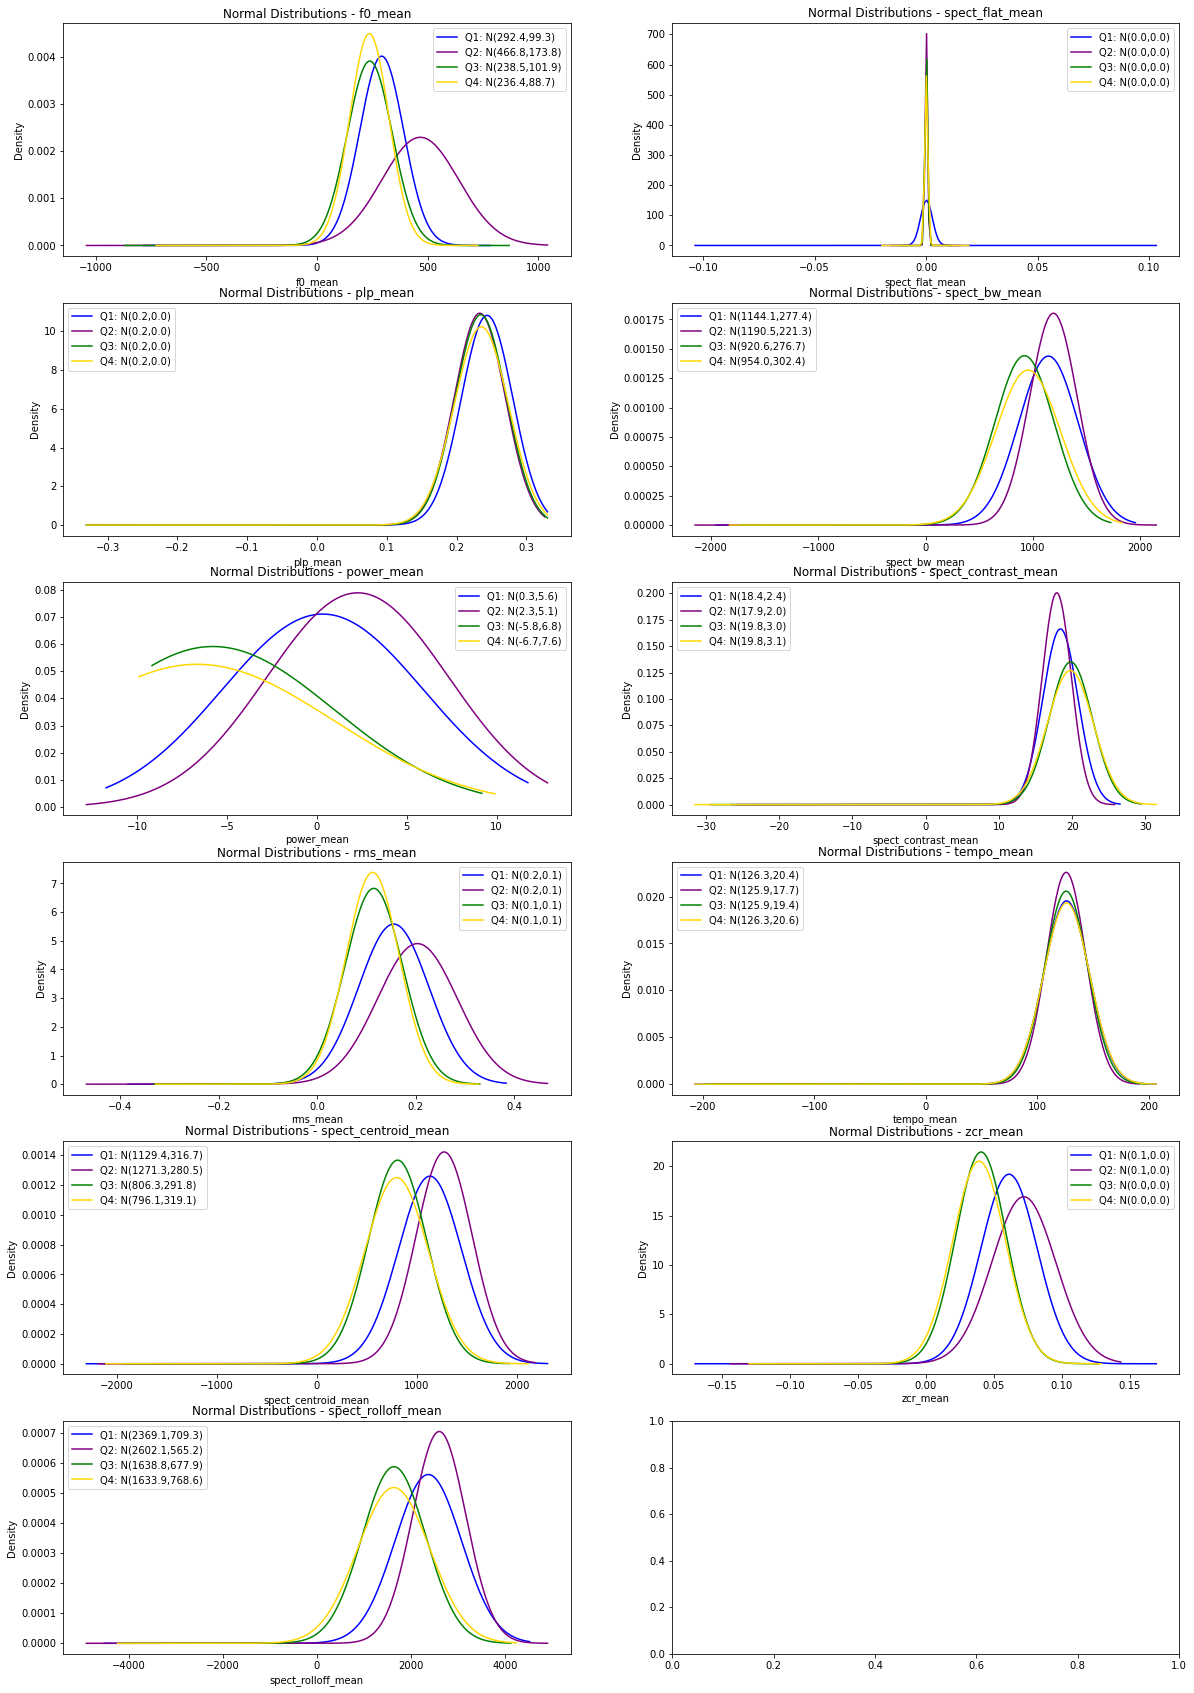

In [43]:
# EAD 2: plot normal distribution curve for core features: RMS, Power, Loudness and F0 

figure, axis = plt.subplots(6, 2, figsize= (20,30))
full_feat_cols = [['f0_mean','plp_mean','power_mean','rms_mean','spect_centroid_mean','spect_rolloff_mean'],
                 ['spect_flat_mean','spect_bw_mean','spect_contrast_mean','tempo_mean','zcr_mean']]

# class - validate class overlap
color_vals = ['blue','purple','green','gold']
#mean_cols = list(X_means.columns)
feat_col_cnt = 0
for feat_cols in full_feat_cols:
    #print(feat_cols)
    row_cnt = 0
    for col_val in feat_cols:
        cntr=0
        norm_df = data_df_raw[['sound_file_class',col_val]]

        for class_val in unique_vals:
            #print(class_val)
            class_df = norm_df[norm_df.sound_file_class==class_val]
            #print(class_df.head())
            mean_val = np.mean(class_df[col_val])
            sd_val = np.std(class_df[col_val])
            x = class_df[col_val]
            x_val = np.arange(max(x)*-1,max(x),0.001)
            label_val = str(class_val)+": N("+str(round(mean_val,1))+","+str(round(sd_val,1))+")"
            axis[row_cnt,feat_col_cnt].plot(x_val,norm.pdf(x_val,mean_val,sd_val),label = label_val, color=color_vals[cntr])    

            #plt.plot(x_val,norm.pdf(x_val,mean_val,sd_val),label = label_val, color=color_vals[cntr])    
            cntr +=1
        axis[row_cnt,feat_col_cnt].legend()
        axis[row_cnt,feat_col_cnt].set_ylabel("Density")
        axis[row_cnt,feat_col_cnt].set_xlabel(str(col_val))
        axis[row_cnt,feat_col_cnt].set_title("Normal Distributions - "+str(col_val))
        row_cnt +=1
    feat_col_cnt+=1
plt.show()

Comments:
1 Normal distribution plots indicate that there is significant class overlap between the classes Q3 and Q4
2 This class overlap can yield to lower accuracy in the model since the model may not be able to determine class boundaries
3 Kernel methods can be deployed to perform boundary detection but may not elevate the accuracy.
4 From a emotion detection stand point, this indicates 2 aspects:
    a Either the anotation of data was highly subjective OR
    b This overlap clearly indicates the bias involved where the detection of emotion boundaries varies with 
    the characterestics of each human brain. In addition, the classes Q3 and Q4 can be interpreted to be 
    inclined towards the "Sad" emotion as per Russel's Circumplex Model: (https://www.researchgate.net/profile/Jukka-Haekkinen/publication/262981399/figure/fig3/AS:392492835983380@1470588992866/Russells-circumplex-model-of-emotion.png).

Based on this perception, the class labels were re-classified into a ordinal variable with 
    a. "1" representing class "Q1"
    b. "2" representing class "Q2" and 
    c. "3" representing class "Q3" and "Q4".

In order to validate the 3 level re-classification of dependent variable, clustering (KMeans) is performed on the data to determine optimal clusters (elbow method) in the dataset using. MeanShift is also used as an additional method

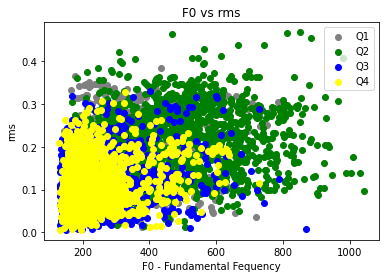

No handles with labels found to put in legend.


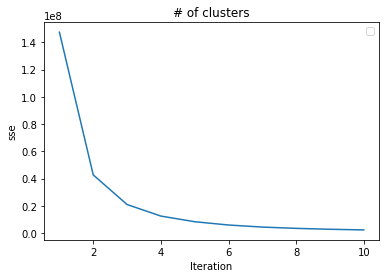

3

In [44]:
# EDA 3: Kmeans cluster to validate classes

#figure, axis = plt.subplots(6, 2, figsize= (20,30))

X = data_df_raw[['f0_mean','rms_mean','sound_file_class_num']]
X_class = X[X.sound_file_class_num==1]
x = X_class.f0_mean
y_class = X_class.rms_mean
plt.scatter(x,y_class,color="gray", label="Q1")
X_class = X[X.sound_file_class_num==2]
x = X_class.f0_mean
y_class = X_class.rms_mean
plt.scatter(x,y_class,color="green", label="Q2")
X_class = X[X.sound_file_class_num==3]
x = X_class.f0_mean
y_class = X_class.rms_mean
plt.scatter(x,y_class,color="blue", label="Q3")
X_class = X[X.sound_file_class_num==4]
x = X_class.f0_mean
y_class = X_class.rms_mean
plt.scatter(x,y_class,color="yellow", label="Q4")

plt.plot(figsize=(20,30))
plt.ylabel("rms")
plt.xlabel("F0 - Fundamental Fequency")
plt.title("F0 vs rms")
plt.legend()
plt.show()

sse_cluster = []
for k in range(1,11,1):
    k_means_model = KMeans(n_clusters = k).fit(X)
    sse_cluster.append(k_means_model.inertia_)
plt.plot(range(1,11,1),sse_cluster)
plt.ylabel("sse")
plt.xlabel("Iteration")
plt.title("# of clusters")
plt.legend()
plt.show()

# Find elbow locator
l1 = KneeLocator(range(1,11), sse_cluster, curve='convex',direction = 'decreasing')
l1.elbow

In [45]:
md("Number of optimal clusters within the dataset are: {} clusters".format(l1.elbow))

Number of optimal clusters within the dataset are: 3 clusters

MeanShift(bandwidth=65)
{0}


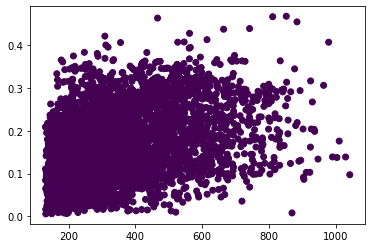

In [46]:
# EDA 4: Meanshift clustering to validate clusters
from sklearn.cluster import MeanShift

clust_model  = MeanShift(bandwidth=65).fit(X)
print(clust_model)
 
# SSpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
#                    eigen_solver=None, eigen_tol=0.0, gamma=1.0,
#                    kernel_params=None, n_clusters=4, n_components=None,
#                    n_init=10, n_jobs=None, n_neighbors=10, random_state=None)

labels = clust_model.labels_
print(set(labels))
#plt.scatter(x[:,0], x[:,1], c=labels)
x = X.f0_mean
y_class = X.rms_mean
plt.scatter(x,y_class,c=labels)
plt.show()

-- Start the modelling
Start with AdaBoost
    - Determine optimal parameters using Grid Search
    - Once the optimal parameters are found, determine the model robustness using 
      multiple samples drawn from the train dataset and validating it against a test
      dataset which is extracted and kept as anonymous to the training process
    - Repeat the above steps for 6 different datasets viz. 
       1. raw dataset with full features, 
       2. hilbert transformed dataset with full features
       3. raw dataset with only "mean" features
       4. hilbert transformed data with only "mean" features
       5. raw dataset with a subset of "mean"features and 
       6. hilbert transformed data with a subset of "mean"features

In [47]:
     
# prepare dataset for modelling - by eliminating columns that contained constant values
X_raw_orig = X_raw_orig[X_raw_orig.columns[~X_raw_orig.columns.isin(cols_to_ignore)]]
X_ht_orig = X_ht_orig[X_ht_orig.columns[~X_ht_orig.columns.isin(cols_to_ignore)]]
X_raw_orig_scaled = X_raw_orig_scaled[X_raw_orig_scaled.columns[~X_raw_orig_scaled.columns.isin(cols_to_ignore)]]
X_ht_orig_scaled = X_ht_orig_scaled[X_ht_orig_scaled.columns[~X_ht_orig_scaled.columns.isin(cols_to_ignore)]]

metrics_df = pd.DataFrame(columns=['dataset', 'model','num_classes','feature_set' ,
                                   'num_feat', 'acc_range', 'auc_range','f1s_range','all_acc'])

In [48]:
# Adaboost classifiers - find the optimal parameters using unscaled raw data 

X = X_raw_orig

# X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
# X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
# X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
#                        'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        

# X = X_raw

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)

# Initial parameters
# gs_parm_grid = {'n_estimators':[10,20,50,100,200,500,1000],
#                'learning_rate':[0.0001,0.001,0.01,0.1,1]}

gs_parm_grid = {'n_estimators':[100,200,500,800,1000,1500],
               'learning_rate':[0.01,0.05,0.1,0.2,0.3]}
ab_clf = AdaBoostClassifier()
cv_model = RepeatedStratifiedKFold(n_splits = 5, n_repeats=2,random_state=1)
grid_search_model_raw = GridSearchCV(estimator = ab_clf, 
                                 param_grid = gs_parm_grid, 
                                 n_jobs=1,
                                 cv=cv_model, 
                                 scoring = 'accuracy',
                                 verbose = 2)

grid_search_score_raw = grid_search_model_raw.fit(X,y)

# cv_scores = cross_val_score(ab_clf, X,y,scoring='accuracy',cv=cv_model,n_jobs=1,error_score='raise')

# print('Accuracy: %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

print(grid_search_score_raw)
print("Best scores:")
print("Best: %f using %s" % (grid_search_score_raw.best_score_, grid_search_score_raw.best_params_))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  24.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  24.0s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  24.7s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  24.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  24.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  24.0s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  23.9s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  24.0s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  24.0s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  24.1s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=  48.3s
[CV] END ...............learning_rate=0.01, n_

[CV] END ..............learning_rate=0.05, n_estimators=1000; total time= 3.3min
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time= 3.3min
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time= 3.3min
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time= 3.3min
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time= 3.3min
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time= 3.3min
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time= 3.3min
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time= 3.3min
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time= 3.3min
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time= 4.9min
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time= 4.9min
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time= 4.9min
[CV] END ..............learn

[CV] END ................learning_rate=0.2, n_estimators=500; total time= 1.6min
[CV] END ................learning_rate=0.2, n_estimators=500; total time= 1.6min
[CV] END ................learning_rate=0.2, n_estimators=500; total time= 1.6min
[CV] END ................learning_rate=0.2, n_estimators=500; total time= 1.6min
[CV] END ................learning_rate=0.2, n_estimators=500; total time= 1.6min
[CV] END ................learning_rate=0.2, n_estimators=500; total time= 1.6min
[CV] END ................learning_rate=0.2, n_estimators=500; total time= 1.6min
[CV] END ................learning_rate=0.2, n_estimators=800; total time= 2.6min
[CV] END ................learning_rate=0.2, n_estimators=800; total time= 2.6min
[CV] END ................learning_rate=0.2, n_estimators=800; total time= 2.6min
[CV] END ................learning_rate=0.2, n_estimators=800; total time= 2.6min
[CV] END ................learning_rate=0.2, n_estimators=800; total time= 2.6min
[CV] END ................lea

For non-augmented sample:

For the sound data, with all features, including MFCC, the parameters for Ada Boost that returned best accuray of 0.534 are learning rate = 0.05 and n_estimators = 800. The parameters were derived based on a 5 fold cross validation with 2 repeats and performing a grid search based on learning rates of 0.01, 0.05, 0.1, 0.2, 0.3 and n_estimators of 100,200,500,800,1000 and 1500.

For augmented sample:

For the sound data, without the MFCC features, the parameters for Ada Boost that returned best accuray of 0.602277 are learning rate = 0.2 and n_estimators = 800. The parameters were derived based on a 5 fold cross validation with 2 repeats and performing a grid search based on learning rates of 0.01, 0.05, 0.1, 0.2, 0.3 and n_estimators of 100,200,500,800,1000 and 1500.


In [49]:
# Adaboost classifiers - find the optimal parameters using scaled raw data 

# X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
# X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
# X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
#                        'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean','chromagram_mean']]        

X = X_raw_orig_scaled

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)

# Initial parameters
# gs_parm_grid = {'n_estimators':[10,20,50,100,200,500,1000],
#                'learning_rate':[0.0001,0.001,0.01,0.1,1]}

gs_parm_grid = {'n_estimators':[100,200,500,800,1000,1500],
               'learning_rate':[0.01,0.05,0.1,0.2,0.3]}
ab_clf = AdaBoostClassifier()
cv_model = RepeatedStratifiedKFold(n_splits = 5, n_repeats=2,random_state=1)
grid_search_model_scaled = GridSearchCV(estimator = ab_clf, 
                                 param_grid = gs_parm_grid, 
                                 n_jobs=1,
                                 cv=cv_model, 
                                 scoring = 'accuracy',
                                 verbose = 2)

grid_search_score_scaled = grid_search_model_scaled.fit(X,y)

# cv_scores = cross_val_score(ab_clf, X,y,scoring='accuracy',cv=cv_model,n_jobs=1,error_score='raise')

# print('Accuracy: %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

print(grid_search_score_scaled)
print("Best scores:")
print("Best: %f using %s" % (grid_search_score_scaled.best_score_, grid_search_score_scaled.best_params_))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  20.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  19.4s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  19.8s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  19.4s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  19.4s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  19.4s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  19.4s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  19.4s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  19.5s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=  19.4s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=  39.3s
[CV] END ...............learning_rate=0.01, n_

KeyboardInterrupt: 

For the scaled sound data, with all features, the parameters for Ada Boost that returned best accuray of 0.534 are learning rate = 0.05 and n_estimators = 800. The parameters were derived based on a 5 fold cross validation with 2 repeats and performing a grid search based on learning rates of 0.01, 0.05, 0.1, 0.2, 0.3 and n_estimators of 100,200,500,800,1000 and 1500.

Does this mean that Adaboost is scaling agnostic or not sensitive to scaling ?

In [13]:
# Ada boosting classifier
model_name = "Ada Boosting"
dataset_names = ['raw','raw-scaled','ht','ht-scaled']
feature_sets = ['All','Mean','Mean Subset']
n_est, learn_rate = 800, 0.05
plot_dict = {}
for feat_set in feature_sets:
    X_raw = X_raw_orig
    X_raw_scaled = X_raw_orig_scaled
    X_ht = X_ht_orig
    X_ht_scaled = X_ht_orig_scaled
    if feat_set == 'Mean':
        X_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_raw_scaled = X_raw_orig_scaled.loc[:,X_raw_orig_scaled.columns.str.contains("_mean")]
        X_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]        
        X_ht_scaled = X_ht_orig_scaled.loc[:,X_ht_orig_scaled.columns.str.contains("_mean")]
    elif feat_set == 'Mean Subset':
        X_means_raw = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
        X_means_scaled = X_raw_orig_scaled.loc[:,X_raw_orig_scaled.columns.str.contains("_mean")]
        X_raw = X_means_raw[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean']]        
        X_raw_scaled = X_means_scaled[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean']]
        X_means_ht = X_ht_orig.loc[:,X_ht_orig.columns.str.contains("_mean")]
        X_means_ht_scaled = X_ht_orig_scaled.loc[:,X_ht_orig_scaled.columns.str.contains("_mean")]
        
        X_ht = X_means_ht[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean']]        
        X_ht_scaled = X_means_ht_scaled[['f0_mean','rms_mean', 'spect_centroid_mean','spect_rolloff_mean',
                               'spect_contrast_mean','zcr_mean', 'power_mean','loudness_mean']]

    for data_pos_val in range(len(dataset_names)):
        X = X_raw
        if dataset_names[data_pos_val]=='raw-scaled':
            X = X_raw_scaled
        elif dataset_names[data_pos_val]=='ht':
            X = X_ht
        elif dataset_names[data_pos_val]=='ht-scaled':
            X = X_ht_scaled
            
#         X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)
#         num_feat = str(len(X_train.columns))
        #print(dataset_names[data_pos_val])
        avg_acc = []
        avg_auc = []
        avg_f1s = []
        plot_name = feat_set+"_"+dataset_names[data_pos_val]+"_"
        #print("Featureset:"  +feat_set+ ", Dataset:" + str(dataset_names[data_pos_val]))
        for trial_num in range(30):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y)
            num_feat = str(len(X_train.columns))
            ab_clf = AdaBoostClassifier(n_estimators=n_est, learning_rate = learn_rate, random_state=0, algorithm="SAMME.R")
            ab_clf.fit(X_train,y_train)
            y_pred = ab_clf.predict(X_test)
            y_pred_prob = ab_clf.predict_proba(X_test)
            curr_acc = round(accuracy_score(y_test, y_pred),3)
            curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
            curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)
            avg_acc.append(curr_acc)
            avg_auc.append(curr_auc)
            avg_f1s.append(curr_f1s)
        plot_dict_tmp = {plot_name+"acc":avg_acc,
                        plot_name+"auc":avg_auc,
                        plot_name+"f1s":avg_f1s}
        plot_dict.update(plot_dict_tmp)
        #print(classification_report(y_test,y_pred))
        avg_acc_val = str(round(np.mean(avg_acc),3))
        acc_range = str(np.min(avg_acc))+" - "+(str(np.max(avg_acc)))

        avg_auc_val = str(round(np.mean(avg_auc),3))
        auc_range = str(np.min(avg_auc))+" - "+(str(np.max(avg_auc)))

        avg_f1s_val = str(round(np.mean(avg_f1s),3))
        f1s_range = str(np.min(avg_f1s))+" - "+(str(np.max(avg_f1s)))

        dict_tmp = {'dataset':dataset_names[data_pos_val],
                    'model':model_name,
                    'num_classes':len(unique_vals),
                    'feature_set':feat_set,
                    'num_feat':num_feat,
                    'acc_range':avg_acc_val+" ("+acc_range+")",
                    'auc_range':avg_auc_val+" ("+auc_range+")",
                    'f1s_range':avg_f1s_val+" ("+f1s_range+")",
                   'all_acc':avg_acc}
    #print(dict_tmp)
        metrics_df = metrics_df.append(dict_tmp, ignore_index=True)
metrics_df.to_csv("model_metrics_4_classes.csv", index= False)
#etrics_df

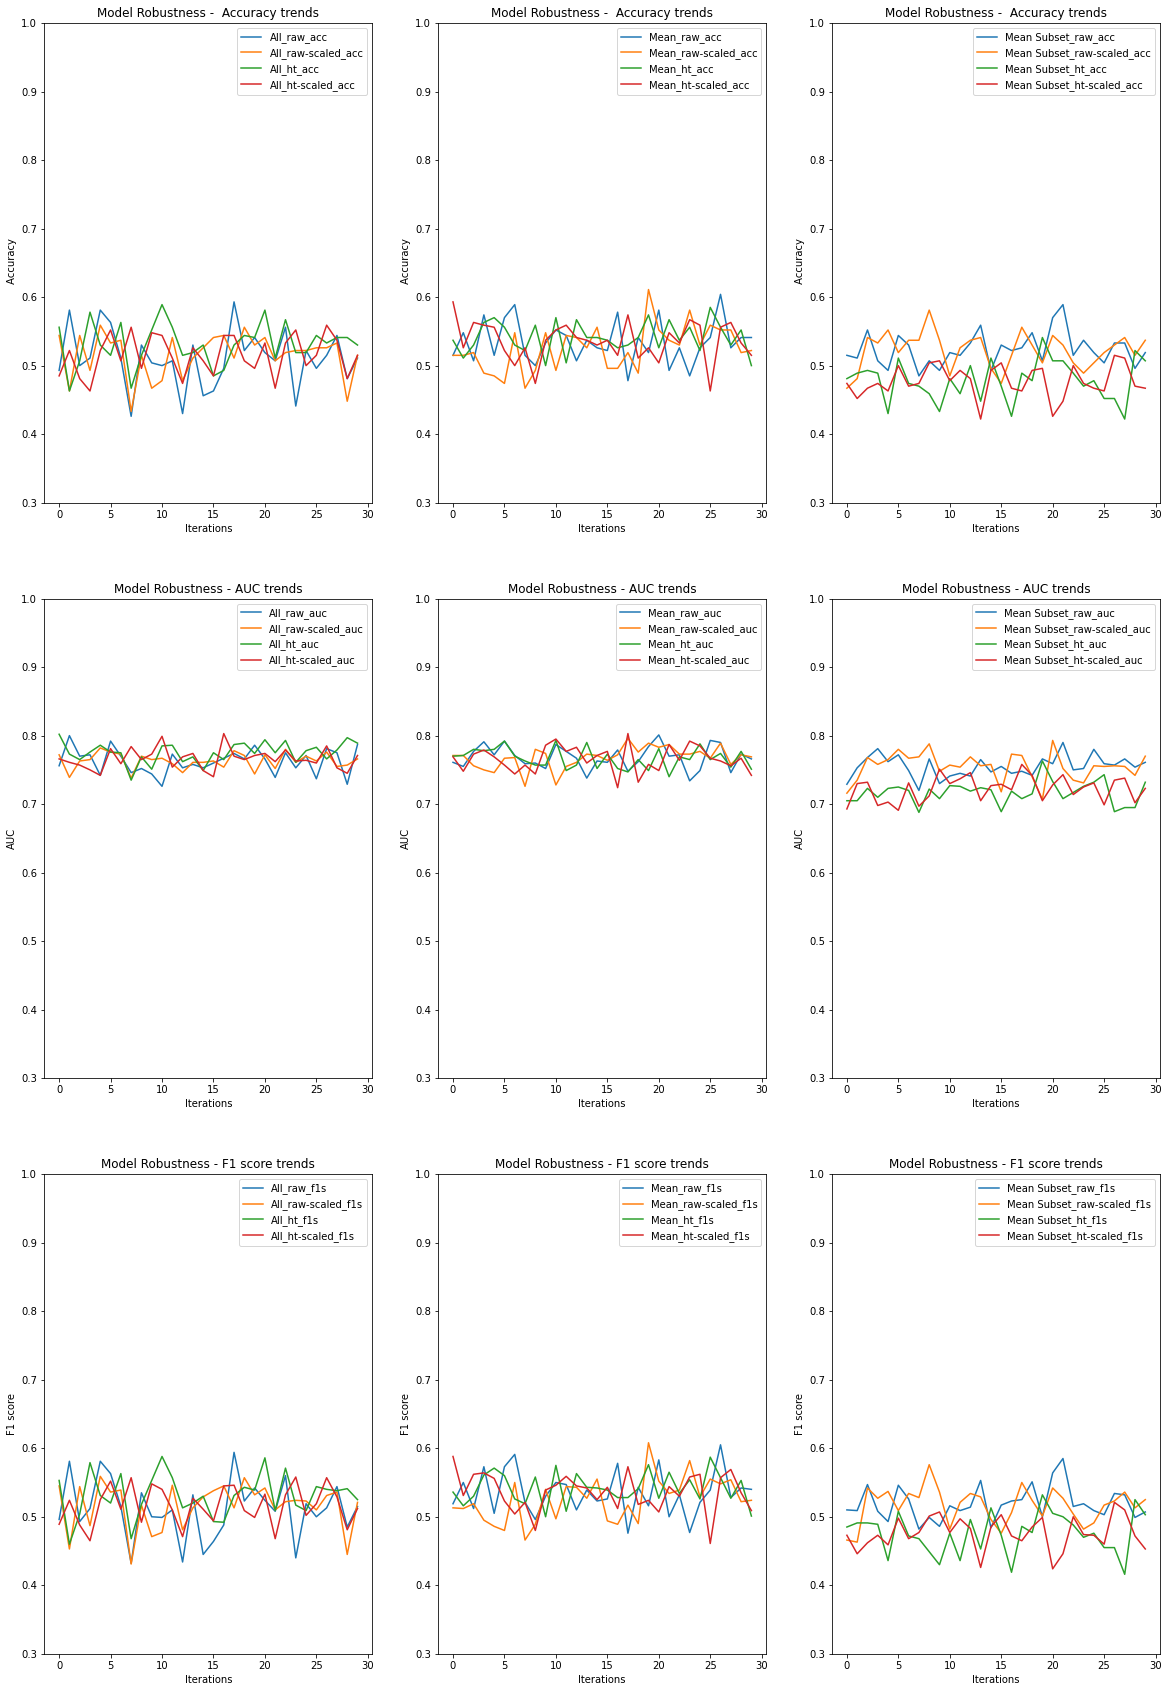

In [14]:
plot_keys = list(plot_dict.keys())
metrics_dict = {'_acc':" Accuracy",
                '_auc': "AUC",
                '_f1s': "F1 score"}

metrics_list = list(metrics_dict.keys())

# Plot the accuracy trends - all feature datasets

fig_rows = len(metrics_list)
fig_cols = fig_rows

figure, axis = plt.subplots(fig_rows,fig_cols, figsize= (20,30))
row_cntr = 0
display_legend = False
for metric_val in metrics_list:
    feature_list = [plot_key for plot_key in plot_keys if plot_key.__contains__(metric_val)]       
    col_cntr = 0
    feat_cntr = 1
    for feature_name in feature_list:    
        y_lab = plot_dict[feature_name]
        x = range(0,len(y_lab),1)
        if feat_cntr%4==0:
            display_legend = True
        #print("["+str(row_cntr)+","+ str(col_cntr)+"]")
        axis[row_cntr, col_cntr].set_ylim(0.3,1)
        axis[row_cntr, col_cntr].plot(x, y_lab,label=feature_name)
        feat_cntr +=1

        if display_legend == True:
            axis[row_cntr, col_cntr].legend()
            axis[row_cntr, col_cntr].set_ylabel(metrics_dict[metric_val])
            axis[row_cntr, col_cntr].set_xlabel("Iterations")
            axis[row_cntr, col_cntr].set_title("Model Robustness - " + str(metrics_dict[metric_val])+" trends")

            col_cntr+=1
            feat_cntr=1
            display_legend = False
        
    row_cntr += 1

Based on the charts above, the final model would be based on a dataset that contains only the mean features within the full dataset since the subset offers higher accuracy range and more robustness. Hence the final model would be:
- dataset: 96 Mean features
- model algortihm: AdaBoost
- model parameters: learning rate = 0.05, n_estimators = 800, random_state = 0

In [15]:
X = X_raw_orig.loc[:,X_raw_orig.columns.str.contains("_mean")]
n_est, learn_rate = 800, 0.05

# Split to train, test and valid
X_all, X_valid, y_all, y_valid = train_test_split(X,y,test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size=0.3,stratify=y_all)

final_ada_model = AdaBoostClassifier(n_estimators=n_est, learning_rate = learn_rate, random_state=0, algorithm="SAMME.R")
final_ada_model.fit(X_train,y_train)
y_pred = final_ada_model.predict(X_test)
y_pred_prob = final_ada_model.predict_proba(X_test)
curr_acc = round(accuracy_score(y_test, y_pred),3)
curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)

curr_acc = accuracy_score(y_test, y_pred)

print("Test Accuracy:" + str(round(curr_acc,3)))
print("Test AUC : "+ str(round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_test,y_pred))

y_pred = final_ada_model.predict(X_valid)
y_pred_prob = final_ada_model.predict_proba(X_valid)
curr_acc = round(accuracy_score(y_valid, y_pred),3)
curr_auc = round(roc_auc_score(y_valid, y_pred_prob, multi_class='ovr'),3)
curr_f1s = round(f1_score(y_valid,y_pred,average="weighted"),3)

curr_acc = accuracy_score(y_valid, y_pred)

print("Validation Accuracy:" + str(round(curr_acc,3)))
print("Validation AUC : "+ str(round(roc_auc_score(y_valid, y_pred_prob, multi_class='ovr'),3)))

print(classification_report(y_valid,y_pred))

Test Accuracy:0.519
Test AUC : 0.778
              precision    recall  f1-score   support

           0       0.44      0.59      0.50        61
           1       0.69      0.56      0.62        62
           2       0.44      0.40      0.42        60
           3       0.56      0.52      0.54        60

    accuracy                           0.52       243
   macro avg       0.53      0.52      0.52       243
weighted avg       0.53      0.52      0.52       243

Validation Accuracy:0.556
Validation AUC : 0.752
              precision    recall  f1-score   support

           0       0.55      0.52      0.54        21
           1       0.63      0.67      0.65        18
           2       0.48      0.58      0.53        26
           3       0.60      0.48      0.53        25

    accuracy                           0.56        90
   macro avg       0.57      0.56      0.56        90
weighted avg       0.56      0.56      0.56        90



In [16]:
# Identify feature importances
feat_imp = final_ada_model.feature_importances_
std = np.std([feat_imp for tree in final_ada_model.estimators_],
             axis=0)
indices = np.argsort(feat_imp)[::-1]


In [17]:
feature_importance = pd.DataFrame({'feature_columns':X.columns[indices],'sig_val':feat_imp[indices]})
feature_importance.to_csv("Feature_Imp_Ada_Boost.csv", index = False)

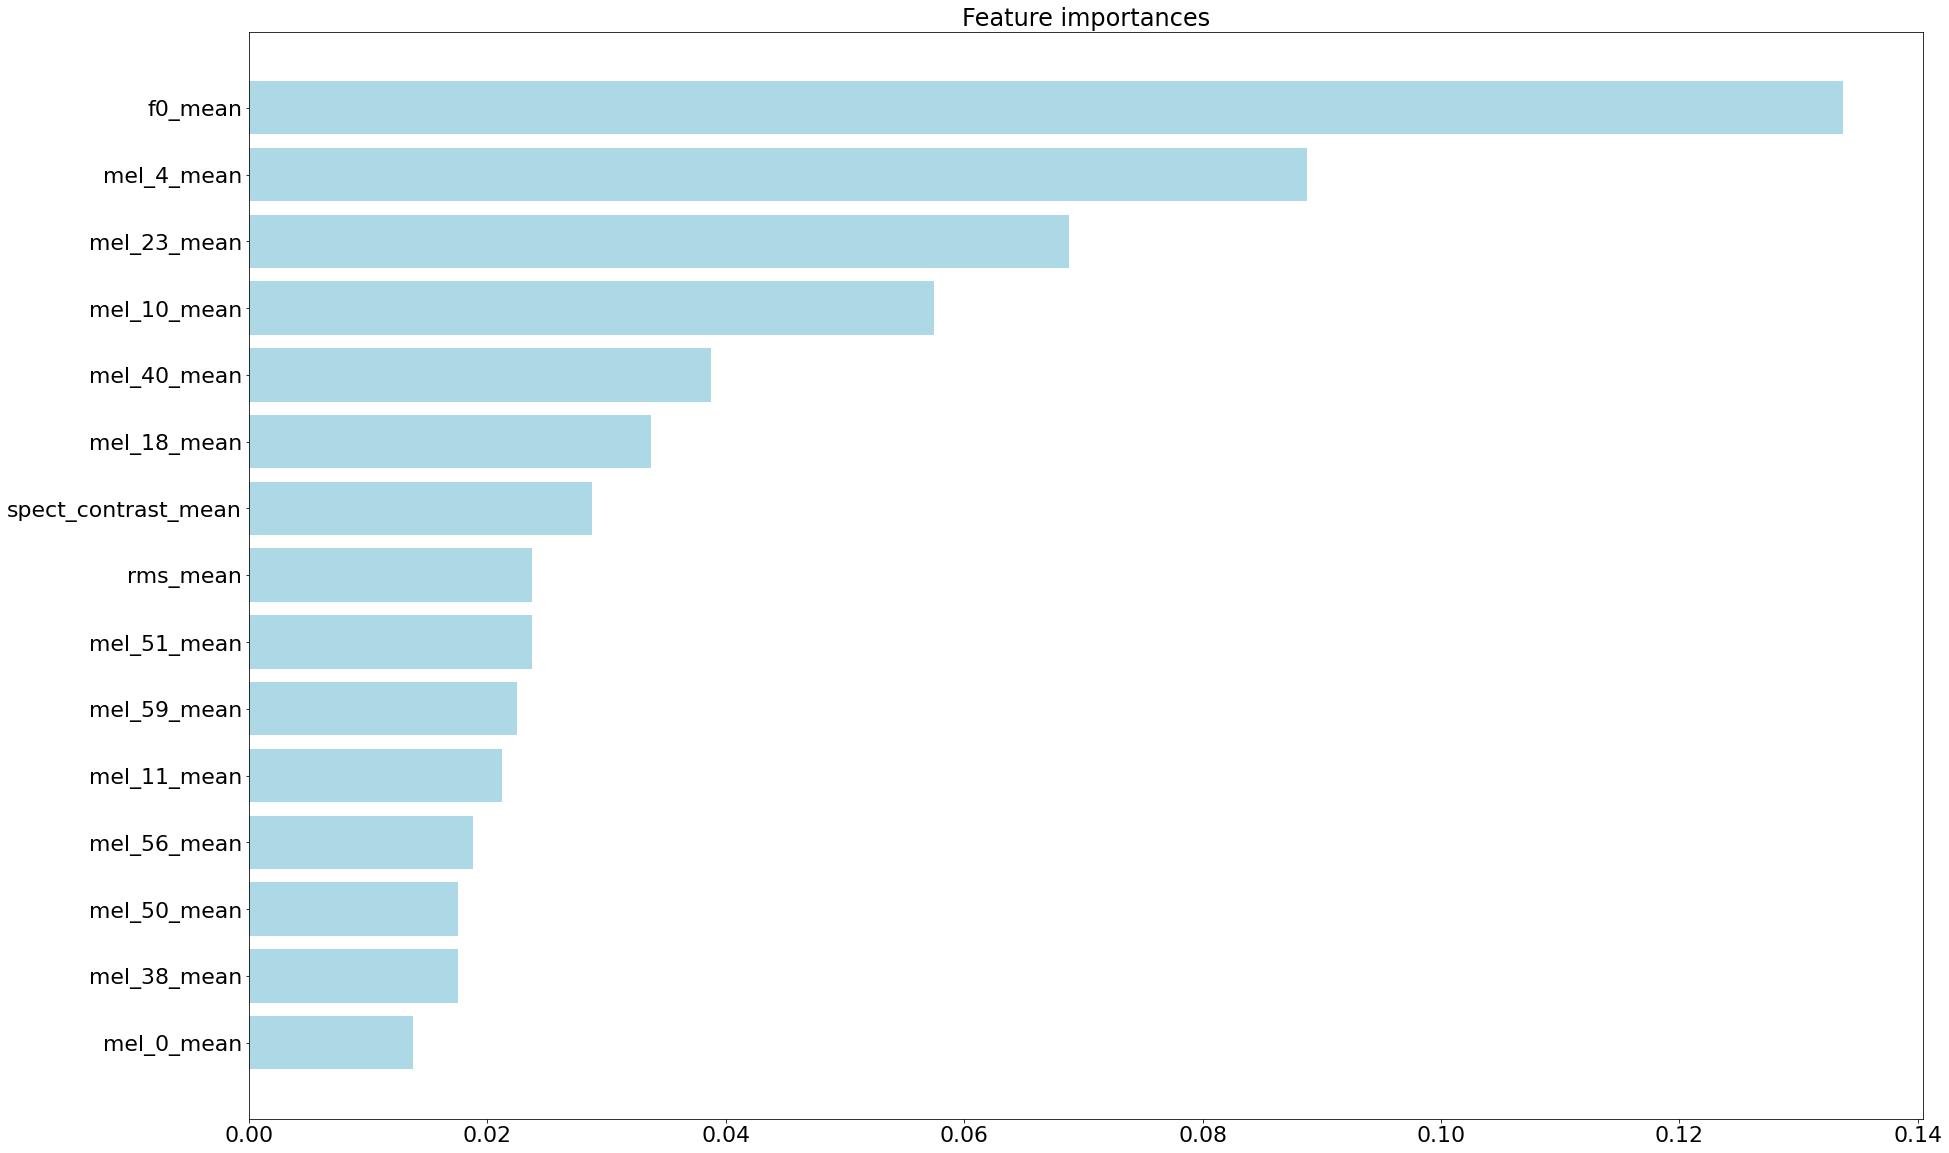

In [29]:
# Plot top 15 feature importances
feature_imp_subset = feature_importance_tmp.iloc[0:15,]
feature_imp_subset.sort_values(by='sig_val', axis=0, inplace=True)
plt.figure(figsize = (30,20))
plt.title("Feature importances", fontsize = 24)
plt.barh(feature_imp_subset.feature_columns,feature_imp_subset.sig_val,color="lightblue")
plt.yticks(fontsize = 22)
plt.xticks(fontsize = 22)
#plt.xticks(x, list(feature_importance.feature_columns)[0:20], rotation="vertical")
plt.show()


In [30]:
cols_to_validate = list(feature_imp_subset.feature_columns)
validate_df = X_valid[cols_to_validate]
validate_df['sound_file_class']= y_valid


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
# get mel columns from validate_df and convert them to hz
mel_cols = list(validate_df.loc[:,validate_df.columns.str.contains('mel_')].columns)
evaluate_df = validate_df.loc[:,~validate_df.columns.str.contains('mel_')]
mel_df = pd.DataFrame()
for col_name in mel_cols:
    mel_df[str(col_name)+"_hz"] = validate_df.apply(lambda x: round(mel_to_hz(x[col_name]),2),axis=1)

evaluate_df = pd.concat([evaluate_df,mel_df], axis=1)

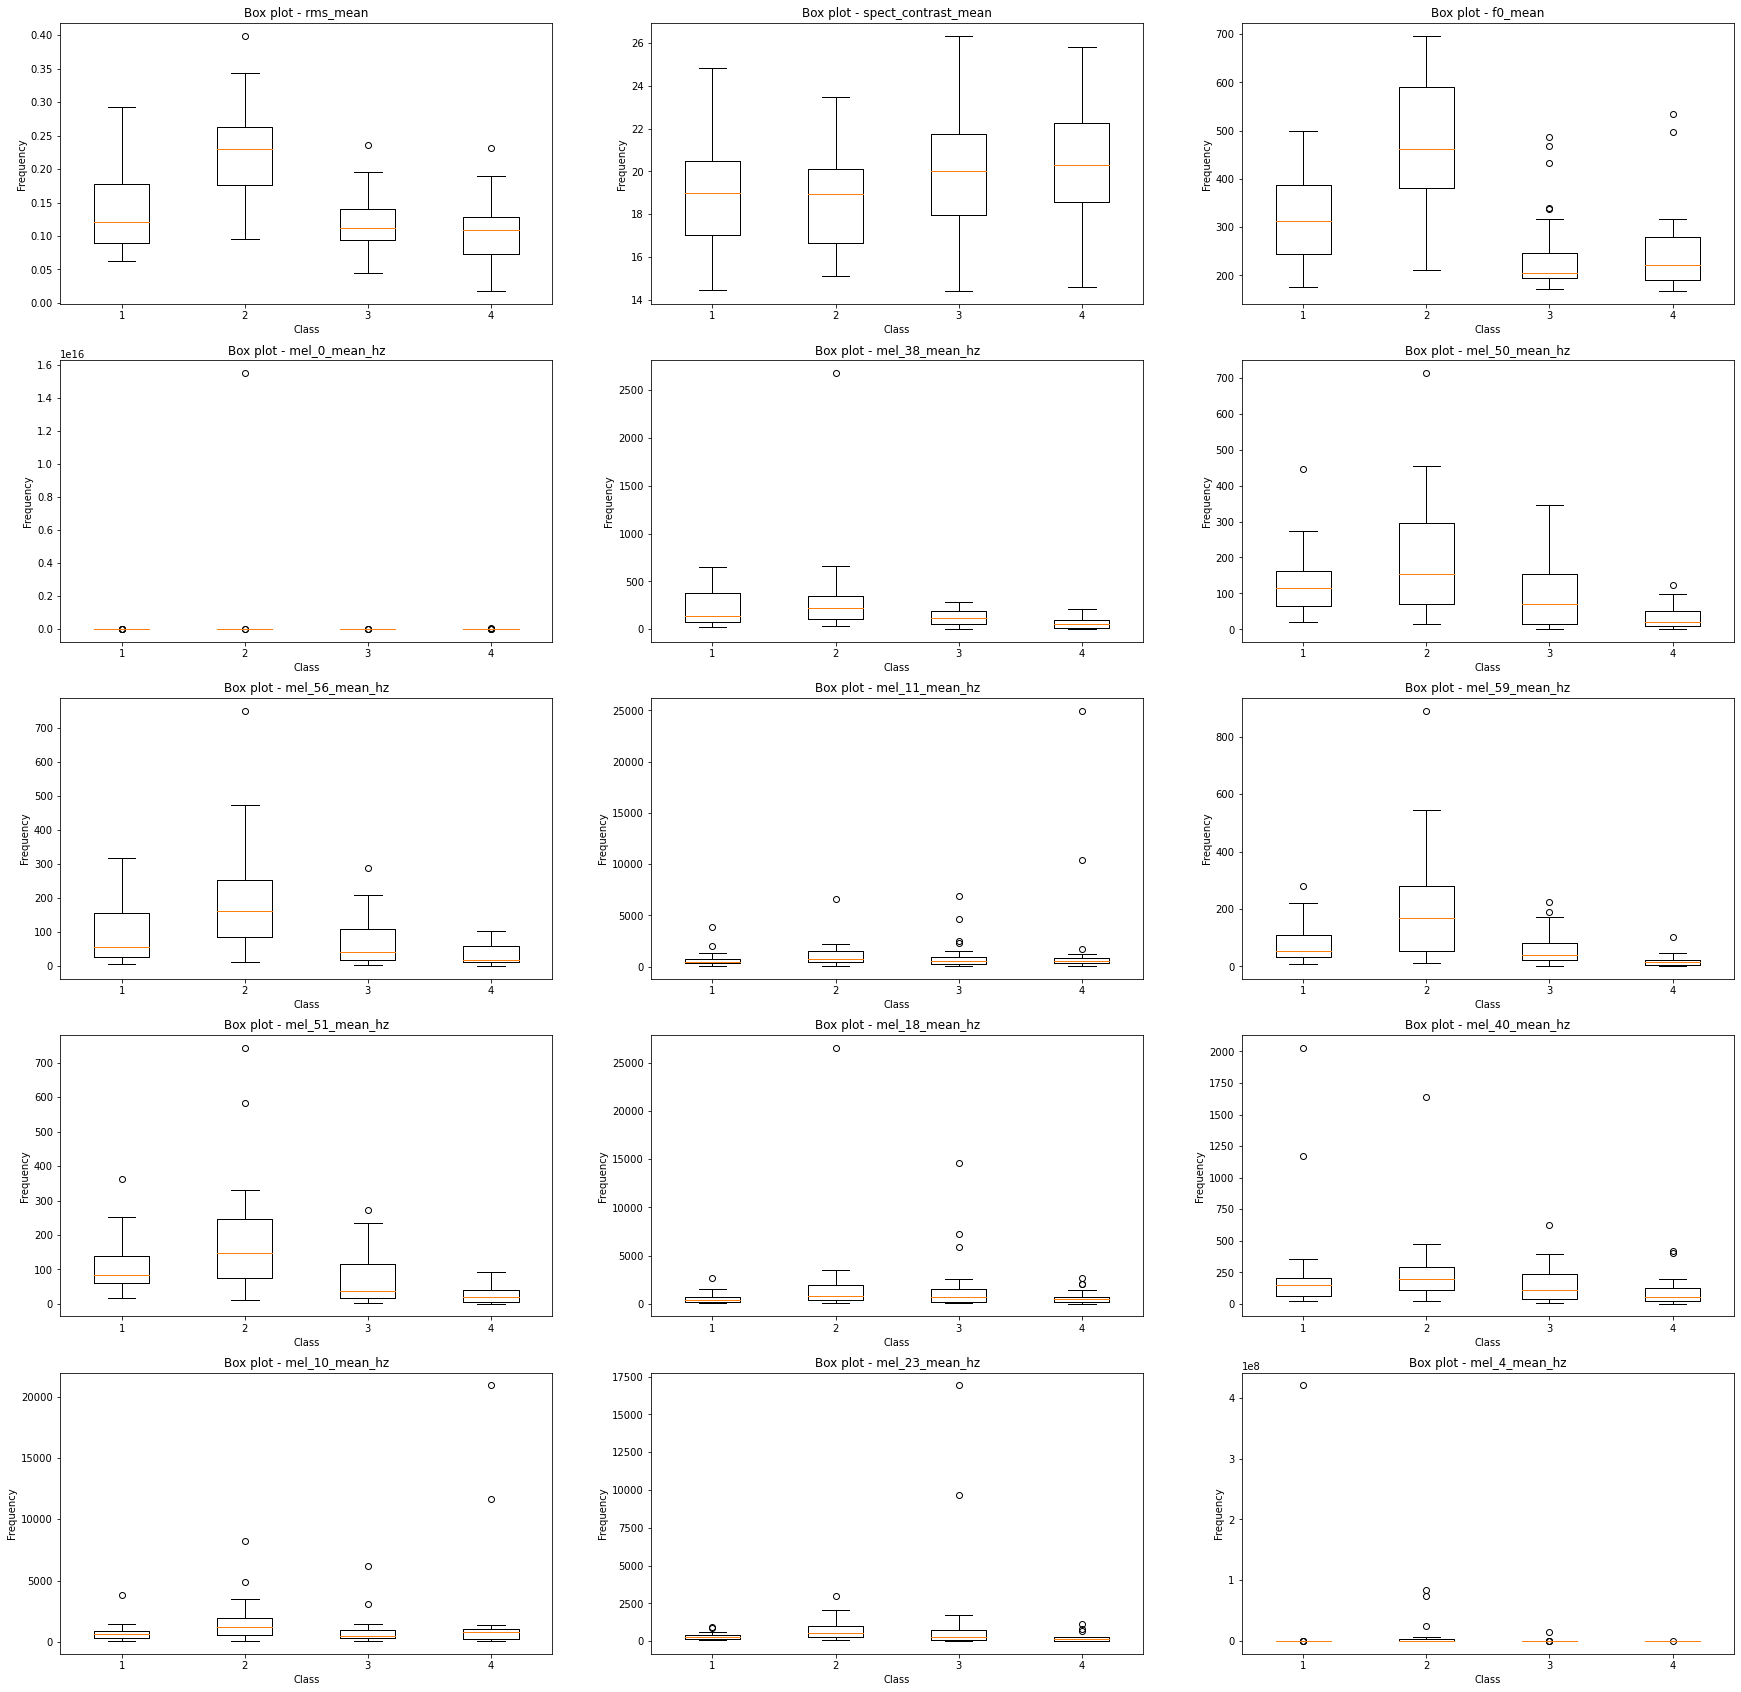

In [32]:
# Plot box plots for the significant columns
num_cols = 3
num_rows = int(np.ceil(len(evaluate_df.columns)+1)/num_cols)

figure, axis = plt.subplots(num_rows, num_cols, figsize= (30,30))
break_flag = 0
row_cntr = 0
col_cntr = 0
class_values = [0,1,2,3]
for col_name in [col_name for col_name in evaluate_df.columns if col_name != 'sound_file_class']:
    if col_cntr==3:
        col_cntr = 0
        row_cntr+= 1
    
    mean_values = []
    for class_val in class_values:
        class_df = evaluate_df[evaluate_df.sound_file_class == class_val]
        mean_values.append(class_df[col_name])
    axis[row_cntr,col_cntr].boxplot(mean_values)    
    axis[row_cntr,col_cntr].set_title("Box plot - " + col_name)
    axis[row_cntr,col_cntr].set_ylabel("Frequency")
    axis[row_cntr,col_cntr].set_xlabel("Class")
    
    col_cntr +=1
    
    if break_flag == 1:
        break
plt.show()

Based on the analysis, the frequency framework (for now, considering only Fundamental fequency and 2 mel frequency components viz mel_43_mean_hz and mel_40_mean_hz, since these were least impacted by the outliers) for musically indcuded emotion would be:

In [33]:
final_df = evaluate_df[['sound_file_class','f0_mean','mel_23_mean_hz','mel_40_mean_hz']]

class_values = [0,1,2,3]
outcome_df = pd.DataFrame({'Emotion Class':['Q1','Q2','Q3','Q4'],
             'Description':['Happy, Surprise','Disgust, Anger, Fear','Sad','Happy']})
f0_list = []
oth_freq_list = []
for class_value in class_values:
    tmp_list = []
    class_df = final_df[final_df.sound_file_class==class_value]
    mean_val = round(np.mean(class_df.f0_mean) ,2)
    min_val = round(np.min(class_df.f0_mean),2) 
    max_val = round(np.max(class_df.f0_mean) ,2)
    range_val = str(mean_val)+" Hz ("+str(min_val)+" Hz - "+ str(max_val) +" Hz )"
    f0_list.append(range_val)
    tmp_list.append(np.mean(class_df.mel_23_mean_hz))
    tmp_list.append(np.min(class_df.mel_23_mean_hz))
    tmp_list.append(np.max(class_df.mel_23_mean_hz))
    
    tmp_list.append(np.mean(class_df.mel_40_mean_hz))
    tmp_list.append(np.min(class_df.mel_40_mean_hz))
    tmp_list.append(np.max(class_df.mel_40_mean_hz))

    mean_val = round(np.mean(tmp_list) ,2)
    min_val = round(np.min(tmp_list),2) 
    max_val = round(np.max(tmp_list),2)
    
    range_val = str(mean_val)+" Hz ("+str(min_val)+" Hz - "+ str(max_val) +" Hz )"
    oth_freq_list.append(range_val)

outcome_df['Fundamental Frequency Range'] = f0_list
outcome_df['Other frequency Range'] = oth_freq_list
outcome_df

,Emotion Class,Description,Fundamental Frequency Range,Other frequency Range
0,Q1,"Happy, Surprise",316.95 Hz (176.31 Hz - 498.21 Hz ),605.11 Hz (19.01 Hz - 2026.91 Hz )
1,Q2,"Disgust, Anger, Fear",473.31 Hz (211.99 Hz - 696.4 Hz ),954.8 Hz (26.18 Hz - 2957.32 Hz )
2,Q3,Sad,248.63 Hz (171.94 Hz - 487.28 Hz ),3185.33 Hz (6.11 Hz - 16925.47 Hz )
3,Q4,Happy,251.69 Hz (166.74 Hz - 534.75 Hz ),310.27 Hz (2.1 Hz - 1131.09 Hz )


Observations:
- Overall accuracy is low as the model is not able to optimally classify the classes 0 ("Q1" and "Q4"), 2 ("Q2") and 3 ("Q3")
- AdaBoost, even with lower accuracy, is a robust model as test and validation accuracies are more or less similar
- class "1", which corresponds to quadrant 2 ("Q2") in the emotion dataset represents predominantly emotions such as "Fear", "Anger", "Disgust" in the Russell's Circumplex Model of emotion. The classification report indicates that the F1-Score, Precision and Recall are high for this class. As a result, it may be concluded that the model can classify the Q2 emotions from the rest. This can be further evaluated in next steps where the whole modelling would be repeated with lesser number of classes after combining the original classes as explanied earlier.
- Box plots indicate presence of outliers in the significant & important column which needs to be treated as its presence may skew the outcome
- The box plots also offers insight into what the frequency framework of musically induced emotion would look like
- The model determines that for a "Q2" quadrant emotion to be induced, the fundamental frequency of the musical piece should be in a higher range.


Next steps:
- Implement band pass filter to cut off lower frequencies and higher frequencies - a way to eliminate outliers
- Repeat above steps with 3 classes and 2 classes to determine change in metrics & observations
- Repeat the whole process with Grandient Boosting algorithm, RandomForest, Hist Gradient Boosting and Voting classifier
- Experiment this process by extracting multiple samples of a single sound so as to have an augmented dataset 
- Expand and fine tune the freqeuncy range
- Derive a metric to measure happiness index so as to measure the probability of "Happy" emotion in a sound signal
- Determine the classification & induced emotion of sound tuned to raaga "Mayamalavagowla" along with other ragas such as "Bhairavi", "Shankarabharanam", "Todi", "Hindolam" and "Hamsadhwani"